In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
import seaborn as sns
import folium

In [2]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
sellers = pd.read_csv("data/olist_sellers_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")

order_items = pd.read_csv("data/olist_order_items_dataset.csv")
order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")

category_translation = pd.read_csv("data/product_category_name_translation.csv")
geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")

tables = [customers , geolocation, order_items, order_payments, order_reviews, orders, products , sellers , category_translation]

## **Exploratory Data Analysis**

The data this analysis will be using is in a form of Relational Database. Before we continue on with the cleaning process, we are going to breakdown each of the table.

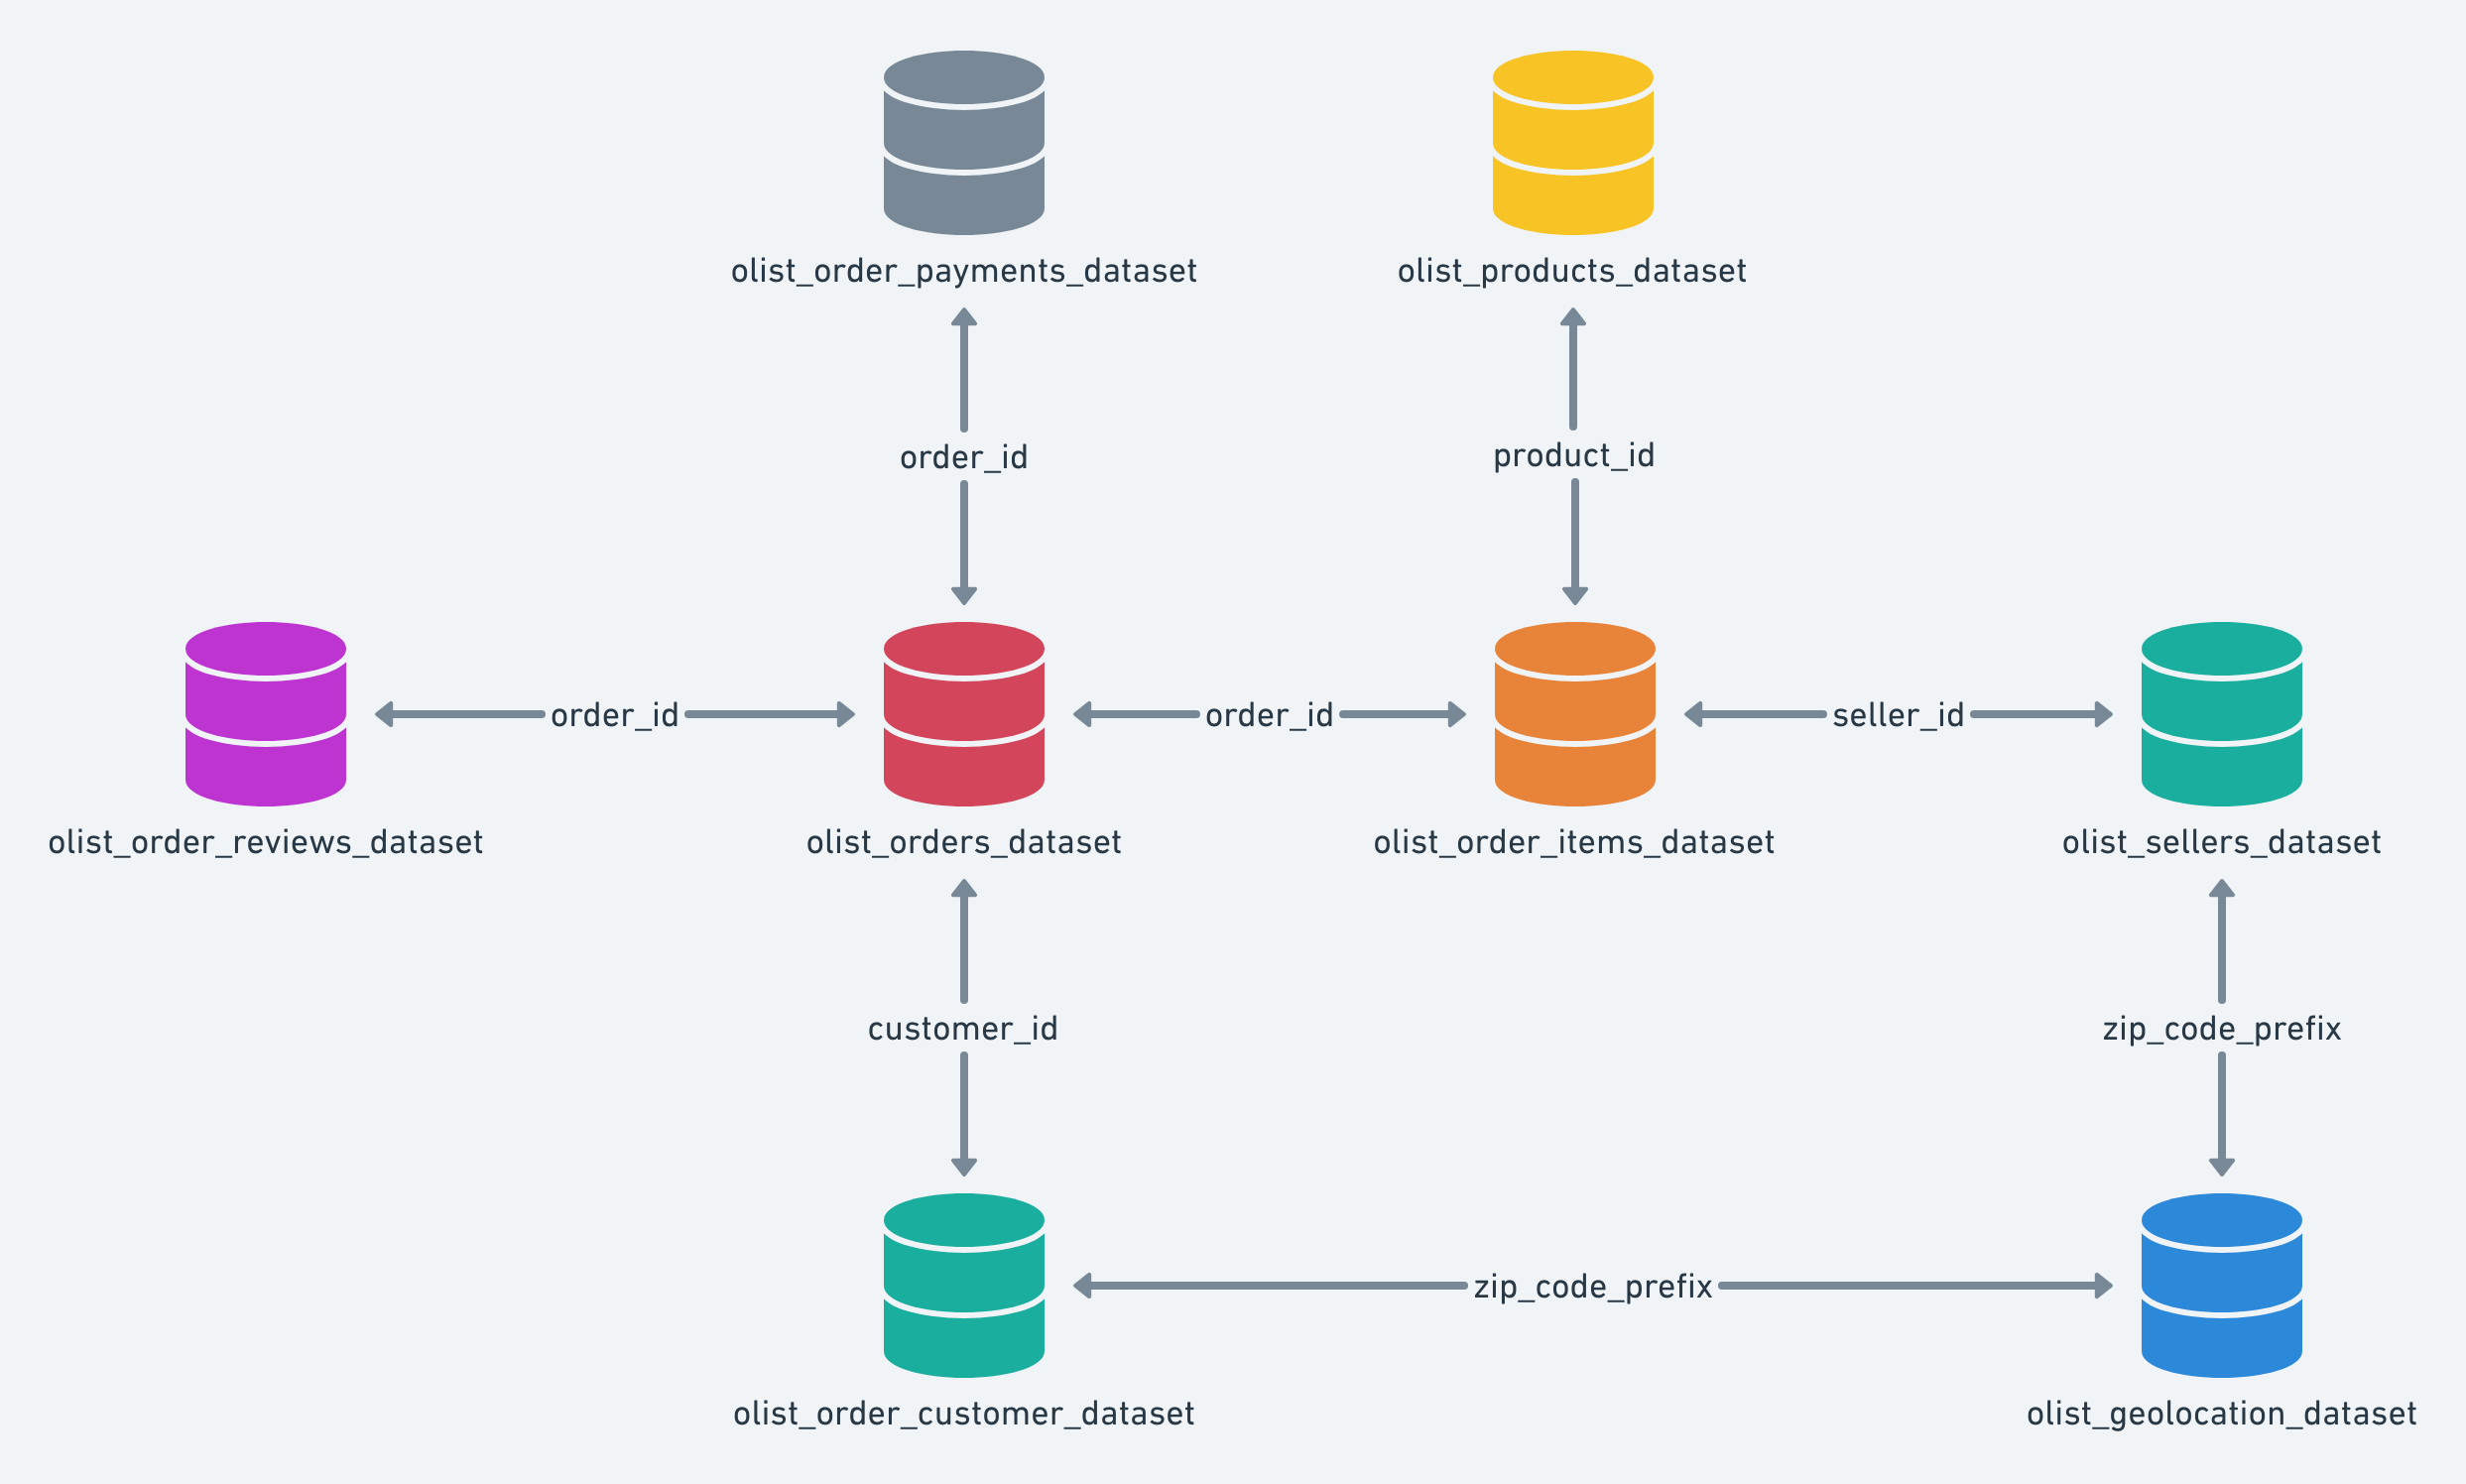

In [3]:
def table_info(table=customers):
    columns_name = []
    data_type = []
    nunique = []
    missing_value = []  
    example = []
    range = []
    
    for column in table.columns:
        columns_name.append(column)
        data_type.append(table[column].dtypes)
        nunique.append(table[column].nunique())
        missing_value.append(table[column].isna().sum())
        if table[column].nunique() > 20:
            example.append(table[column][1])
        else:
            example.append(table[column].unique())

        
    info = pd.DataFrame({'columns':columns_name,
                  'dtype' : data_type, 'nunique':nunique,'missing_value': missing_value, 'example':example})
    return info

### **`customers` table**
---
This table consists of data about the buying customer who initiate a transaction.

In [4]:
display(customers.head(),
customers.shape)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


(99441, 5)

In [5]:
table_info(customers)

,columns,dtype,nunique,missing_value,example
0,customer_id,object,99441,0,18955e83d337fd6b2def6b18a428ac77
1,customer_unique_id,object,96096,0,290c77bc529b7ac935b93aa66c333dc3
2,customer_zip_code_prefix,int64,14994,0,9790
3,customer_city,object,4119,0,sao bernardo do campo
4,customer_state,object,27,0,SP


- `customer_unique_id` are a anonimyzed customer name. 
- `customer_id` have the same amount of nunique value as the length, meaning that the customer id is likely to be the unique primary key of the table.
- Most of the column consists of categorical data, except the `customer_zip_code_prefix` which had numerical.
- The `customer_zip_code_prefix` acts as a foreign key that connects this table with `geolocation` table.
- There are no missing value in this table.

#### **Top 10 States with Most Number of Customer**
--- 

In [6]:
top10state = customers.groupby(by='customer_state').count()['customer_id'].sort_values(ascending=False).head(10).to_frame()
top10state['%'] = (top10state['customer_id'] / len(customers))
top10state['%'] = top10state['%'].round(2)
top10state

,customer_id,%
customer_state,,
SP,41746,0.42
RJ,12852,0.13
MG,11635,0.12
RS,5466,0.05
PR,5045,0.05
SC,3637,0.04
BA,3380,0.03
DF,2140,0.02
ES,2033,0.02


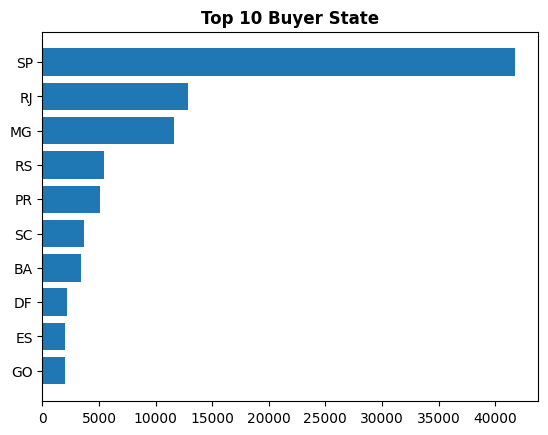

In [7]:
top10state = top10state.iloc[::-1]
plt.title('Top 10 Buyer State', fontweight='bold')
plt.barh(top10state.index,width=top10state['customer_id'])
plt.show()

- **SP** (Sao Paolo) is the state with most number of Olist customers, with **41.746** customer which is almost half **42%** of all customers are from the state. 
- **RJ** (Rio de Janeiro) and **MG** (Minas Garais) came in second and third with a small difference with 13% and 12%, but a huge gap from the market leader (SP).
- Beside these three, the market share in the other states are not surpassing the **5%** mark.

#### **Top 10 Cities with Most Number of Customer**
--- 

In [8]:
top10city = customers.groupby(by='customer_city').count()['customer_id'].sort_values(ascending=False).head(10).to_frame()
top10city['%'] = (top10city['customer_id'] / len(customers))
top10city['%'] = top10city['%'].round(2)
top10city

,customer_id,%
customer_city,,
sao paulo,15540,0.16
rio de janeiro,6882,0.07
belo horizonte,2773,0.03
brasilia,2131,0.02
curitiba,1521,0.02
campinas,1444,0.01
porto alegre,1379,0.01
salvador,1245,0.01
guarulhos,1189,0.01


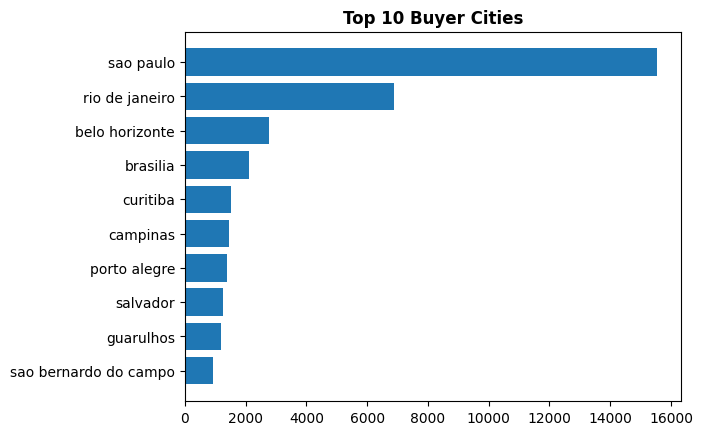

In [9]:
top10city = top10city.iloc[::-1]
plt.title('Top 10 Buyer Cities', fontweight='bold')
plt.barh(top10city.index,width=top10city['customer_id'])
plt.show()

- Sao Paolo becomes the city with most number of Olist customers, with 15540 customer which is **16%** of all customers are from the city. 
- Rio de Janeiro came in second in a relatively huge gap with **6.882** customer, consisting of **7%** of all customers.
- Beside the top 5, the number of customer of the other cities are all below 1% market share.

### **`sellers` table**
---
This table consists of data about the e-comerce sellers who provides the products.

In [10]:
display(sellers.head(),
sellers.shape)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


(3095, 4)

In [11]:
table_info(sellers)

,columns,dtype,nunique,missing_value,example
0,seller_id,object,3095,0,d1b65fc7debc3361ea86b5f14c68d2e2
1,seller_zip_code_prefix,int64,2246,0,13844
2,seller_city,object,611,0,mogi guacu
3,seller_state,object,23,0,SP


- `seller_id` have the same amount of nunique value as the length, meaning that the column is likely to be the unique primary key of the table.
- Most of the column consists of categorical data, except the `seller_zip_code_prefix` which had numerical.
- The `customer_zip_code_prefix` acts as a foreign key that connects this table with `geolocation` table.
- There are no missing value in this table.

#### **Top 10 States with Most Number of Seller**
--- 

In [12]:
top10state = sellers.groupby(by='seller_state').count()['seller_id'].sort_values(ascending=False).head(10).to_frame()
top10state['%'] = (top10state['seller_id'] / len(sellers))
top10state['%'] = top10state['%'].round(2)
top10state

,seller_id,%
seller_state,,
SP,1849,0.60
PR,349,0.11
MG,244,0.08
SC,190,0.06
RJ,171,0.06
RS,129,0.04
GO,40,0.01
DF,30,0.01
ES,23,0.01


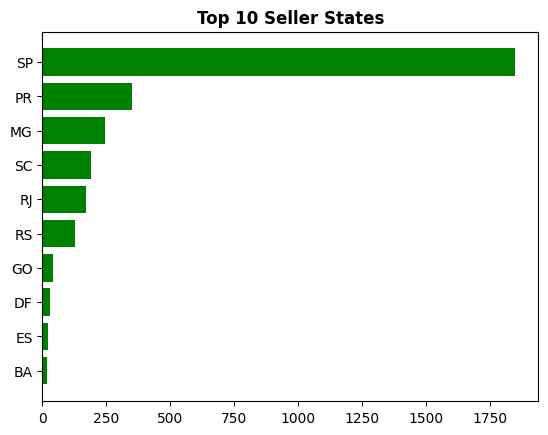

In [13]:
top10state = top10state.iloc[::-1]
plt.title('Top 10 Seller States', fontweight='bold')
plt.barh(top10state.index,width=top10state['seller_id'], color='g')
plt.show()

- **SP** (Sao Paolo) is the state with most number of Olist sellers, with **1.849** sellers, a staggering **60%** of all sellers are from SP. 
- **PR** (Parana) came in second with 11%, a very huge gap from the market leader (SP).
- Beside the top 5, the seller share in the other states are not surpassing the **5%** mark.

#### **Top 10 Cities with Most Number of Seller**
--- 

In [14]:
top10city = sellers.groupby(by='seller_city').count()['seller_id'].sort_values(ascending=False).head(10).to_frame()
top10city['%'] = (top10city['seller_id'] / len(sellers))
top10city['%'] = top10city['%'].round(2)
top10city

,seller_id,%
seller_city,,
sao paulo,694,0.22
curitiba,127,0.04
rio de janeiro,96,0.03
belo horizonte,68,0.02
ribeirao preto,52,0.02
guarulhos,50,0.02
ibitinga,49,0.02
santo andre,45,0.01
campinas,41,0.01


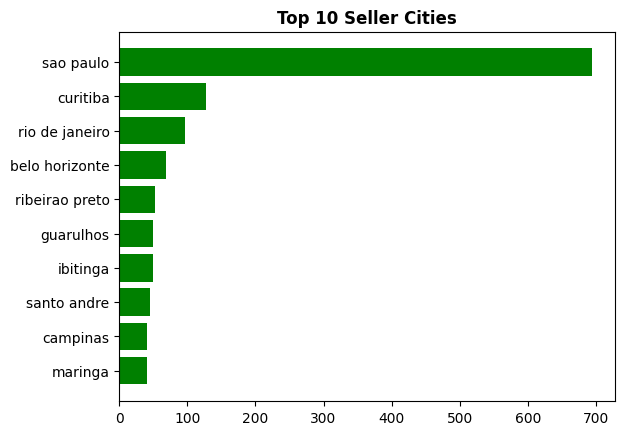

In [15]:
top10city = top10city.iloc[::-1]
plt.title('Top 10 Seller Cities', fontweight='bold')
plt.barh(top10city.index,width=top10city['seller_id'], color='g')
plt.show()

- Identical to the buyer data, Sao Paolo becomes the city with most number of Olist sellers, with 694 seller, meaning that **22%** of all seller are from the city. 
- Curitiba came in second in a relatively huge gap with **127** sellers, consisting of **4%** of all sellers.
- Beside the top 2, the number of sellers of the other cities are all below 3% market share.

### **`orders` table**
---
This table contains the historical transaction data that was made in the Olist e-commerce ecosystem. 

In [16]:
display(orders.head(),
orders.shape)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


(99441, 8)

In [17]:
table_info(orders)

,columns,dtype,nunique,missing_value,example
0,order_id,object,99441,0,53cdb2fc8bc7dce0b6741e2150273451
1,customer_id,object,99441,0,b0830fb4747a6c6d20dea0b8c802d7ef
2,order_status,object,8,0,"[delivered, invoiced, shipped, processing, una..."
3,order_purchase_timestamp,object,98875,0,2018-07-24 20:41:37
4,order_approved_at,object,90733,160,2018-07-26 03:24:27
5,order_delivered_carrier_date,object,81018,1783,2018-07-26 14:31:00
6,order_delivered_customer_date,object,95664,2965,2018-08-07 15:27:45
7,order_estimated_delivery_date,object,459,0,2018-08-13 00:00:00


In [18]:
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
orders[date_columns] = orders[date_columns].apply(pd.to_datetime)

In [19]:
table_info(orders)

,columns,dtype,nunique,missing_value,example
0,order_id,object,99441,0,53cdb2fc8bc7dce0b6741e2150273451
1,customer_id,object,99441,0,b0830fb4747a6c6d20dea0b8c802d7ef
2,order_status,object,8,0,"[delivered, invoiced, shipped, processing, una..."
3,order_purchase_timestamp,datetime64[ns],98875,0,2018-07-24 20:41:37
4,order_approved_at,datetime64[ns],90733,160,2018-07-26 03:24:27
5,order_delivered_carrier_date,datetime64[ns],81018,1783,2018-07-26 14:31:00
6,order_delivered_customer_date,datetime64[ns],95664,2965,2018-08-07 15:27:45
7,order_estimated_delivery_date,datetime64[ns],459,0,2018-08-13 00:00:00


#### **Order Status**

For the analysis, it is important to understand the outome of a transaction given a number of its data. 

In [20]:
status = orders.groupby(by='order_status').count()['order_id'].sort_values(ascending=False).to_frame()
status['%'] = (status['order_id']/len(orders)).round(2)
status

,order_id,%
order_status,,
delivered,96478,0.97
shipped,1107,0.01
canceled,625,0.01
unavailable,609,0.01
invoiced,314,0.00
processing,301,0.00
created,5,0.00
approved,2,0.00


In [21]:
process = ['shipped', 'invoiced', 'processing', 'created', 'approved']
unsuccessful = ['canceled','unavailable']
print(f'''
=== SUCCESSFUL RATIO ===

Finished Transactions       : {sum(status[status.index == 'delivered']['order_id'])}   ({sum(status[status.index == 'delivered']['%'])*100} %)
Processed Transactions      : {sum(status[status.index.isin(process)]['order_id'])}    ({sum(status[status.index.isin(process)]['%'])*100} %)
Unsuccessful Transactions   : {sum(status[status.index.isin(unsuccessful)]['order_id'])}    ({sum(status[status.index.isin(unsuccessful)]['%'])*100} %)
''')


=== SUCCESSFUL RATIO ===

Finished Transactions       : 96478   (97.0 %)
Processed Transactions      : 1729    (1.0 %)
Unsuccessful Transactions   : 1234    (2.0 %)



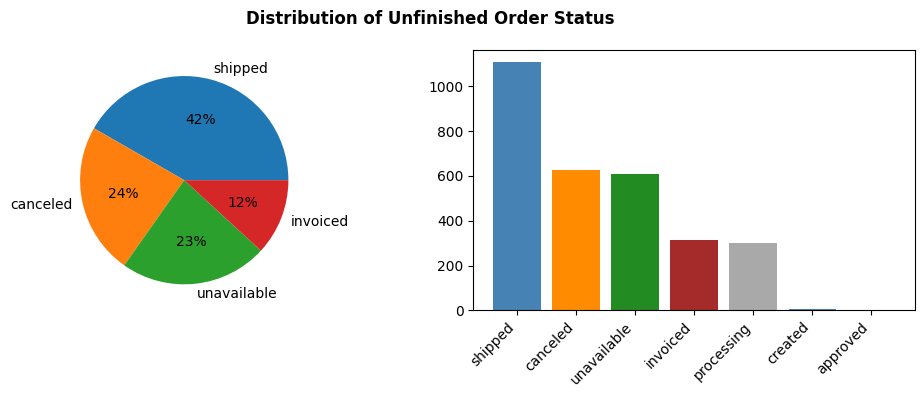

In [22]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
plt.suptitle('Distribution of Unfinished Order Status', fontweight='bold')

axs[0].pie(status['order_id'].iloc[1:-3],autopct='%.0f%%', labels=status.index[1:-3])
axs[1].bar(status.index[1:], height=status['order_id'].iloc[1:], color=['steelblue','darkorange','forestgreen','brown', 'darkgrey'])
axs[1].set_xticklabels(status.index[1:], rotation=45, ha='right')

plt.tight_layout()
plt.show()

- 97% of the data that we are dealing are delivered data, this is the data that are important to our segmenting purpose because it's the data of the transaction that are successful and producing customers.
- The data has a very small ratio of unsuccesful data. With only 2% of the transaction are considered a failure. Consisting of canceled and unavailable transaction.

#### **Metric Distribution and Outliers**

Giving that the transaction progress data are in a datetime format, to profoundly understand the distribuion of the order data, we need to create a few metrics that represents the time difference between the transaction processs. We will also be using these meterics to find outliers within the data.
The metrics we are going to use are:

- `purchase to approval`  : the intervals from the time the order was purchased by the buyer until the time the order was approved by the seller. For different distribution visualization, this variable will be represented by days and seconds.
- `approval to delivered` : the intervals from the time the order was approved by the buyer until the time the order was delivered to the buyer. This variable will be represented in days.
- `purchase to delivered` : the intervals from the time the order was purchased until the time the order was delivered to the buyer. This variable will be represented in days.
- `estimation accuracy`   : the accuracy of estimation time, the difference between the estimated time and real time the product was delivered. This variable will be represented in days.




In [23]:
# making the metrics
order_time = orders.copy()
order_time['purchase to approval (seconds)'] =  (order_time['order_approved_at'] - order_time['order_purchase_timestamp']).dt.seconds
order_time['purchase to approval (days)'] =  (order_time['order_approved_at'] - order_time['order_purchase_timestamp']).dt.days
order_time['approval to delivered'] =  (order_time['order_delivered_customer_date'] - order_time['order_approved_at']).dt.days
order_time['purchase to delivered'] =  (order_time['order_delivered_customer_date'] - order_time['order_purchase_timestamp']).dt.days
order_time['estimation accuracy'] =  (order_time['order_delivered_customer_date'] - order_time['order_estimated_delivery_date']).dt.days

metric =  ['purchase to approval (days)', 'approval to delivered','purchase to delivered', 'estimation accuracy']
metric2 =  ['purchase to approval (seconds)', 'approval to delivered','purchase to delivered', 'estimation accuracy']

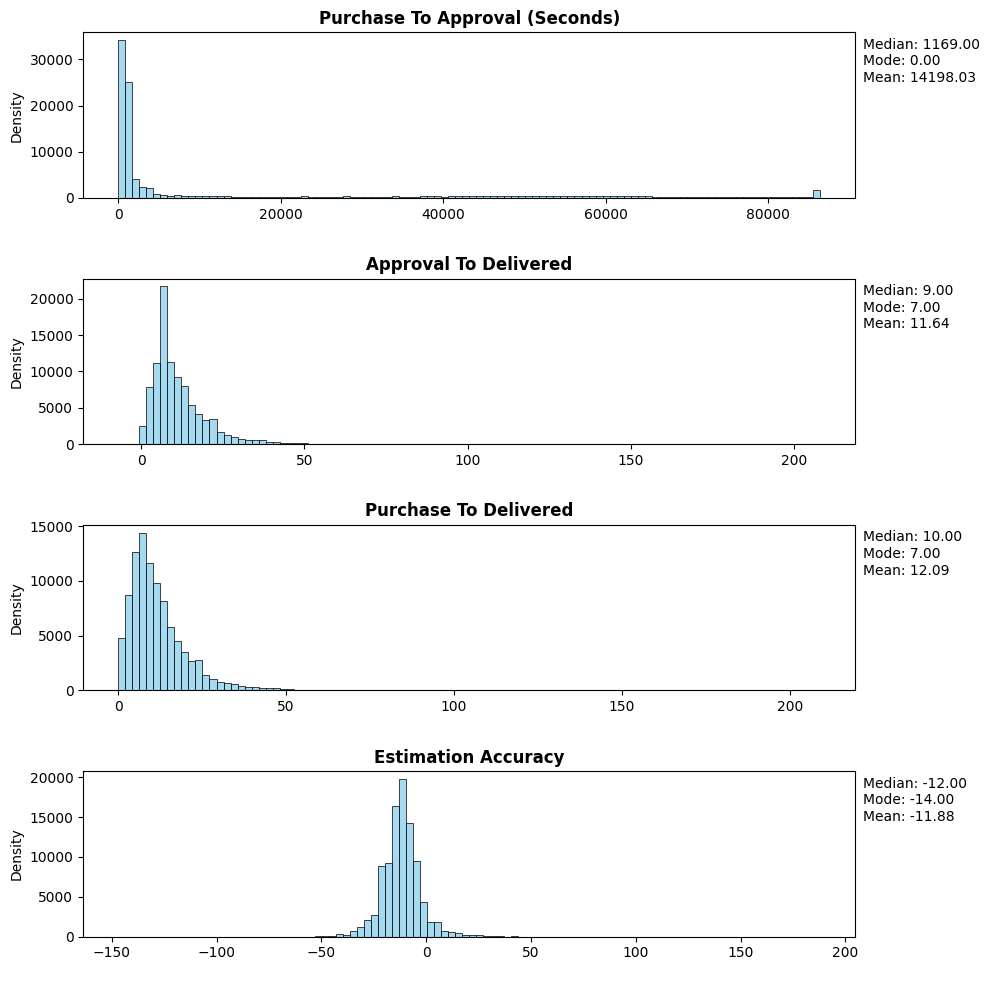

In [24]:
fig, axs = plt.subplots(4,1,figsize=(10,10))

for idx, column in enumerate(metric2):
    sns.histplot(order_time[column], ax=axs[idx], bins=100, color='skyblue')

    median = order_time[column].median()
    mean = order_time[column].mean()
    mode = order_time[column].mode().values[0] 
    
    # Annotate subplot with median and mode
    axs[idx].text(1.01, 0.9, f'Median: {median:.2f}', transform=axs[idx].transAxes, fontsize=10)
    axs[idx].text(1.01, 0.8, f'Mode: {mode:.2f}', transform=axs[idx].transAxes, fontsize=10)
    axs[idx].text(1.01, 0.7, f'Mean: {mean:.2f}', transform=axs[idx].transAxes, fontsize=10)
 

    axs[idx].set_xlabel(' ')
    axs[idx].set_ylabel('Density')
    axs[idx].set_title(f'{column.title()}',fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

- Most of the time intervals' distribution are right skewed, meaning that even though there are some outliers, the majority of transaction are not taking a significantly long amount of time.
- The `purchase to approval`'s range are wide. But the mode value are 0, meaning that most of the transaction are approved quickly. 
- As seen on the `purchase to delivered` the average time of transaction to be delivered is 12 days.
- The estimation accuracy shows that most of the products are being delivered before the estimated time.

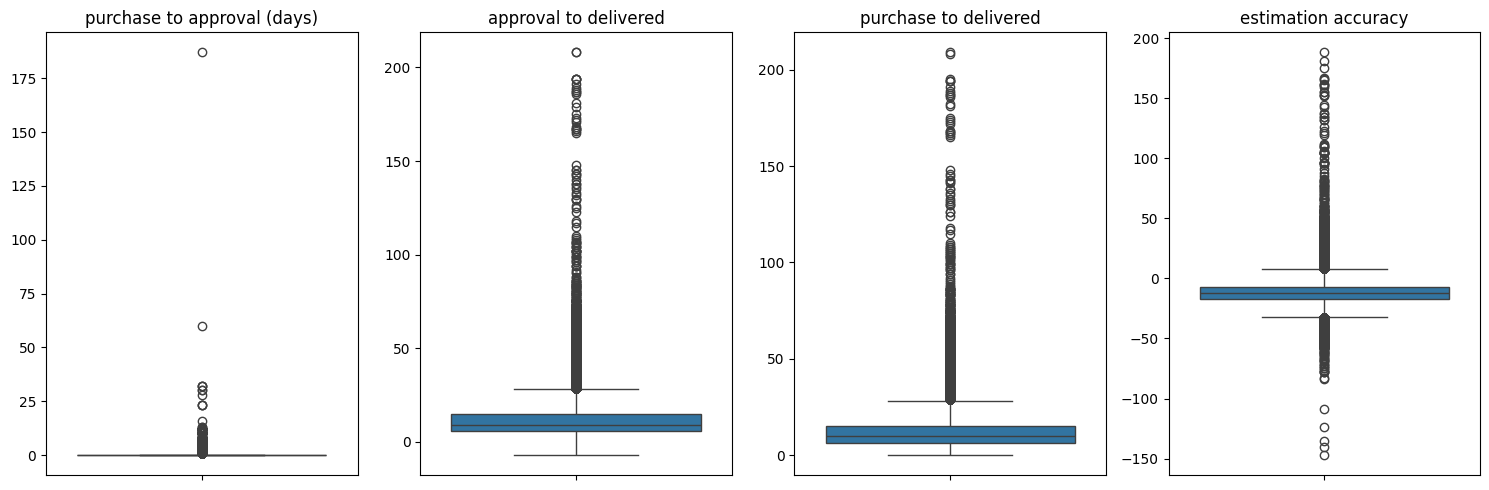

In [25]:
fig, axs = plt.subplots(1,4,figsize=(15,5))

for idx, column in enumerate(metric):
    sns.boxplot(order_time[column], ax=axs[idx])
    axs[idx].set_title(f'{column}')
    axs[idx].set_ylabel('')
plt.tight_layout()
plt.show()

- As you can see from the boxplot there are numbers of outliers in the data, but considering the data cardinalities are huge we need to understand the character of this outliers.
- the `purchase to approval` outliers are mostly transactions that takes more than 1 day to be approved, **but** there a few transaction that takes more than 20 days to be processed with 187 days as the longest transaction to be approved, this should be analyzed further to understand, considering it is logically almost impossible for a buyer to want to wait that long for an approval. 
- `approval to delivered` also has many outlier that is more than 50 days, but in the context od the data this could be in affect of the products and location of the transaction.
- the `estimation accuracy` boxplot also shows that there are some inaccuracy that takes up to more than 50 days, which is most likely to be impossible.

### `products` table
---
This table consist of the data following the descriptions of the products that are being sold in the Olist e-commerce ecosystem.

In [26]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [27]:
table_info(products)

,columns,dtype,nunique,missing_value,example
0,product_id,object,32951,0,3aa071139cb16b67ca9e5dea641aaa2f
1,product_category_name,object,73,610,artes
2,product_name_lenght,float64,66,610,44.0
3,product_description_lenght,float64,2960,610,276.0
4,product_photos_qty,float64,19,610,"[1.0, 4.0, 2.0, 3.0, 5.0, 9.0, 6.0, nan, 7.0, ..."
5,product_weight_g,float64,2204,2,1000.0
6,product_length_cm,float64,99,2,30.0
7,product_height_cm,float64,102,2,18.0
8,product_width_cm,float64,95,2,20.0


In [28]:
products.groupby(by='product_category_name').count()['product_id'].sort_values(ascending=False).head(10).to_frame()

,product_id
product_category_name,
cama_mesa_banho,3029
esporte_lazer,2867
moveis_decoracao,2657
beleza_saude,2444
utilidades_domesticas,2335
automotivo,1900
informatica_acessorios,1639
brinquedos,1411
relogios_presentes,1329


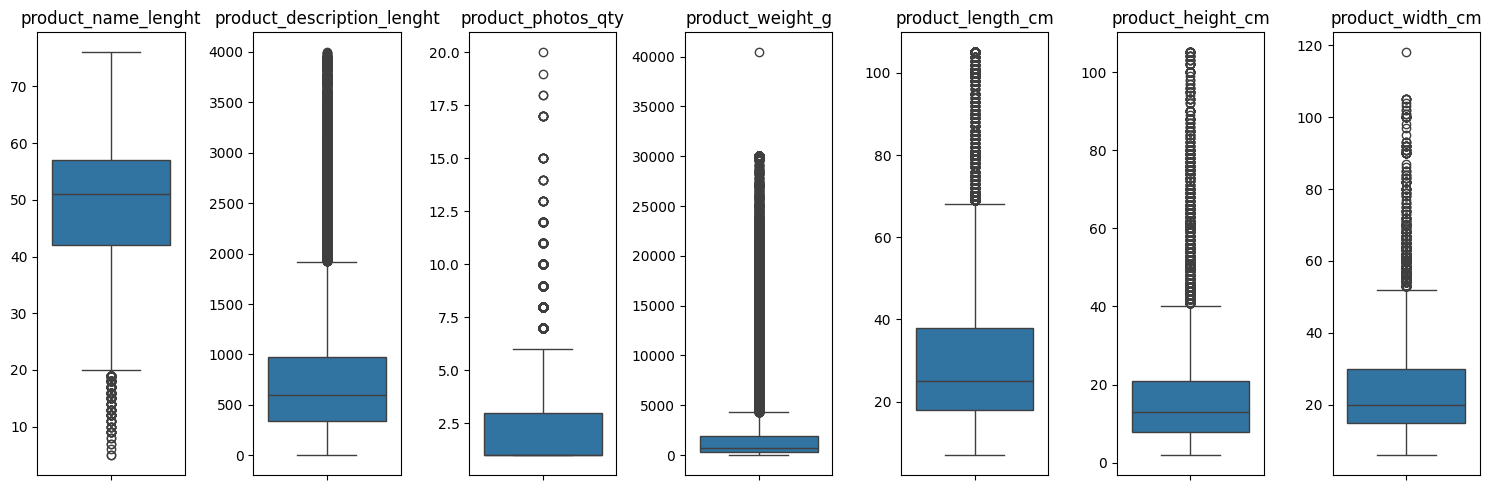

In [29]:
prod = ['product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm']

fig, axs = plt.subplots(1,7,figsize=(15,5))

for idx, column in enumerate(prod):
    sns.boxplot(products[column], ax=axs[idx])
    axs[idx].set_title(f'{column}')
    axs[idx].set_ylabel('')
plt.tight_layout()
plt.show()

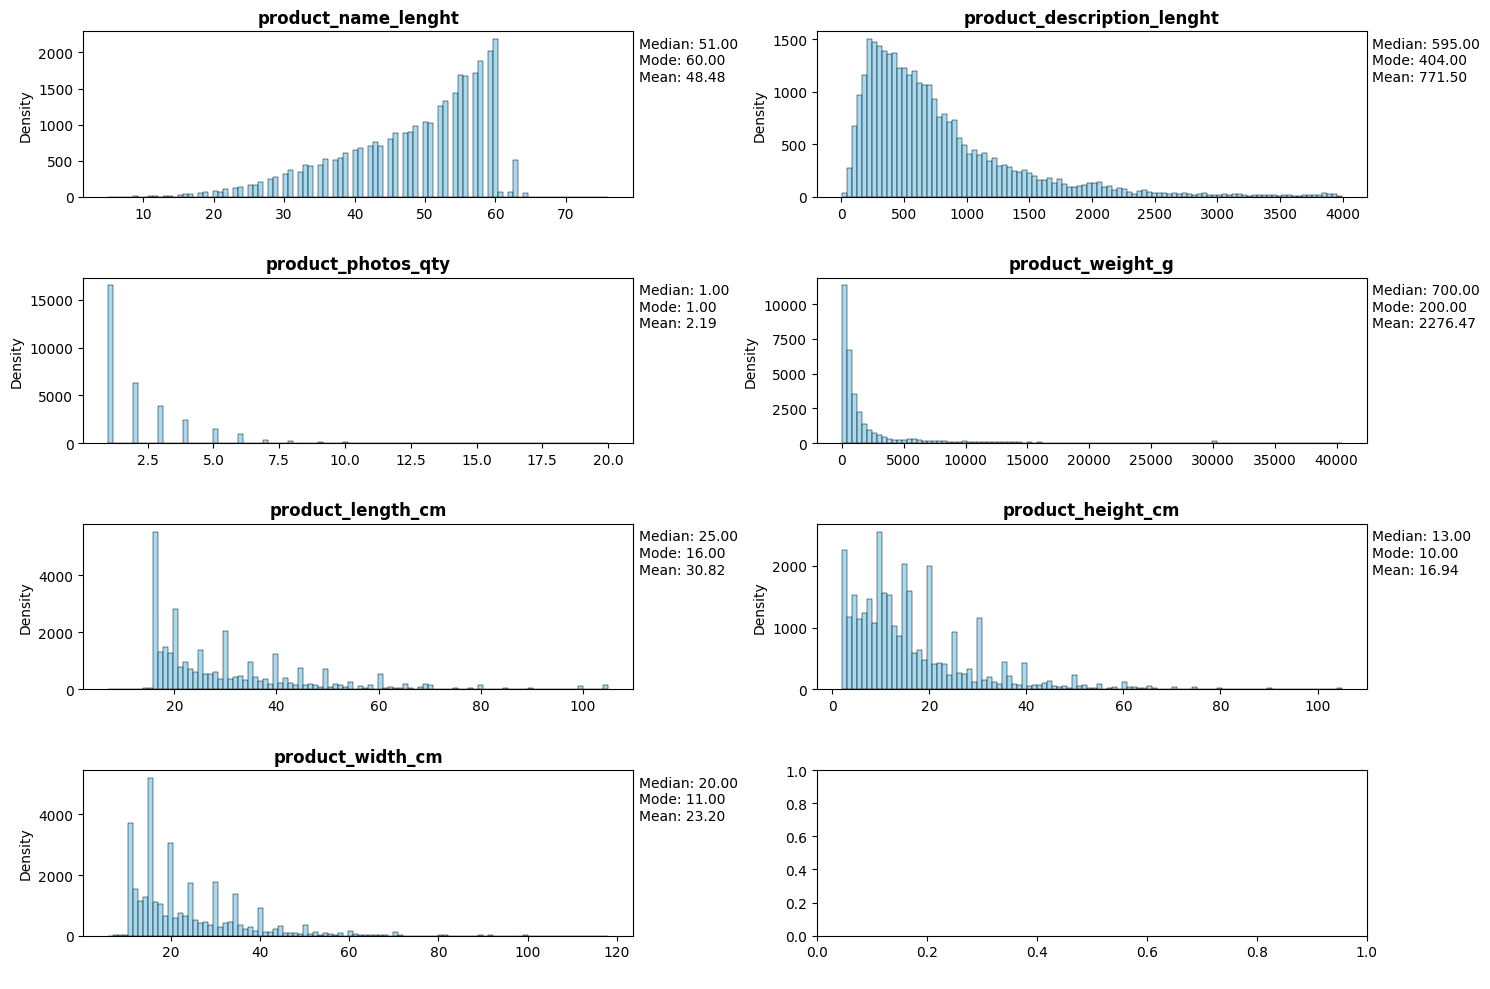

In [30]:
fig, axs = plt.subplots(4, 2, figsize=(15, 10)) 

for idx, column in enumerate(prod):
    row = idx // 2  
    col = idx % 2   

    sns.histplot(products[column], ax=axs[row, col], bins=100, color='skyblue')

    median = products[column].median()
    mean = products[column].mean()
    mode = products[column].mode().values[0]

    axs[row, col].text(1.01, 0.9, f'Median: {median:.2f}', transform=axs[row, col].transAxes, fontsize=10)
    axs[row, col].text(1.01, 0.8, f'Mode: {mode:.2f}', transform=axs[row, col].transAxes, fontsize=10)
    axs[row, col].text(1.01, 0.7, f'Mean: {mean:.2f}', transform=axs[row, col].transAxes, fontsize=10)

    axs[row, col].set_xlabel(' ')
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_title(f'{column}', fontsize=12, fontweight='bold')

plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9, hspace=0.5)
plt.tight_layout()
plt.show()


- The product length

In [31]:
# analyzing the translation of the heavy products
heavy = products[products['product_weight_g'] > 15000].groupby(by='product_category_name').count()['product_id'].sort_values(ascending=False).to_frame()
heavy.merge(category_translation[['product_category_name', 'product_category_name_english']], on='product_category_name', how='left').drop(columns=['product_category_name'])['product_category_name_english'].values

array(['office_furniture', 'furniture_decor', 'housewares',
       'bed_bath_table', 'sports_leisure', 'auto', 'baby',
       'health_beauty', 'pet_shop', 'luggage_accessories', 'garden_tools',
       'kitchen_dining_laundry_garden_furniture', 'toys',
       'furniture_living_room', 'cool_stuff', 'home_appliances_2',
       'construction_tools_construction', 'musical_instruments',
       'small_appliances', 'home_appliances', 'electronics',
       'home_construction', 'air_conditioning', 'furniture_bedroom',
       'signaling_and_security', 'industry_commerce_and_business',
       'computers_accessories', 'stationery',
       'agro_industry_and_commerce', 'furniture_mattress_and_upholstery',
       'home_confort', 'watches_gifts', 'costruction_tools_garden',
       'fashion_bags_accessories', 'art', 'christmas_supplies',
       'party_supplies', 'market_place', 'computers', 'perfumery',
       'consoles_games', 'small_appliances_home_oven_and_coffee',
       'construction_tools_lights'

- As we can see in the array above most of the heavy products are in the category of home appliances and electronics, so the outliers in this columns are permissable.

### **`order_items` table**
---
This is the details of the order data's price.

In [32]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [33]:
table_info(order_items)

,columns,dtype,nunique,missing_value,example
0,order_id,object,98666,0,00018f77f2f0320c557190d7a144bdd3
1,order_item_id,int64,21,0,1
2,product_id,object,32951,0,e5f2d52b802189ee658865ca93d83a8f
3,seller_id,object,3095,0,dd7ddc04e1b6c2c614352b383efe2d36
4,shipping_limit_date,object,93318,0,2017-05-03 11:05:13
5,price,float64,5968,0,239.9
6,freight_value,float64,6999,0,19.93


There ae 3 additional columns:
- `shipping_limit_date`: the time limit of the products being shipped by the sellers.
- `price`              : the price in which the product is sold to the customers.
- `freight_value      `: the shipping / delivery cost the customer need to pay.

### **`order_payments` table**
---
This is the details of the order data's price.

In [ ]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


### **`order_reviews` table**
---
This is the details of the order data's price.

In [ ]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


### **`geolocation` table**
---
This table consists of data about brazil's geographical location. This table serves to helps geospatial visualization of the data.

In [ ]:
display(geolocation.head(),
geolocation.shape)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


(1000163, 5)

In [ ]:
table_info(geolocation)

,columns,dtype,nunique,missing_value,example
0,geolocation_zip_code_prefix,int64,19015,0,1046
1,geolocation_lat,float64,717360,0,-23.546081
2,geolocation_lng,float64,717613,0,-46.64482
3,geolocation_city,object,8011,0,sao paulo
4,geolocation_state,object,27,0,SP


- `geolocation_zip_code_prefix` have the same amount of nunique value as the length, meaning that the customer id is likely to be the unique primary key of the table. 
- The `geolocation_zip_code_prefix`, `geolocation_lat`, `geolocation_lng` are numerical data. With the rest being a categorical data.
- The `geolocation_lat` and `geolocation_lng` serves as a spatial data that can helps later geo visualizations.
- The `customer_zip_code_prefix` connects this table with `customer` and `sellers` table.
- There are no missing value in this table.